In [1]:
###################################################################################################
# Project: Mathematical Finance MSc Dissertation @QMUL 2019/2020
#          Machine Learning and numerical techniques for option pricing.
# Lenguaje: Python / jupyter
# Description:
#
# References: 
# Git Control:https://github.com/camiloblanco/BlackScholesDL
# Author - Year:Camilo Blanco Vargas - 2020
# Mail - Web:mail@camiloblanco.com - www.camiloblanco.com
###################################################################################################

In [2]:
# Import the necesary libraries
import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import keras.backend as kb
import tensorflow as tf

#Using Nvidia GPU card
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
#https://stackoverflow.com/questions/43990046/tensorflow-blas-gemm-launch-failed
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)


Using TensorFlow backend.


True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1


In [3]:
# Read datset from excel file
data_file='datasets\data10ks.csv'
df_full = pd.read_csv(data_file)
# Display the head of the dataset
df_full.head()

,time,strike_price,stock_price,volatility,interest_rate,type_o1,price_o1,delta_o1,gamma_o1,theta_o1,type_o2,price_o2,delta_o2,gamma_o2,theta_o12
0,1.940020,44.73,1.50,0.5732,0.0909,call,0.000034,0.000140,0.000454,-0.000184,put,35.998389,-0.999860,0.000454,3.408417
1,1.493695,346.92,96.87,0.6909,0.0070,call,4.247081,0.140912,0.002733,-6.187030,put,250.688630,-0.859088,0.002733,-3.783849
2,1.064463,292.88,188.56,0.7094,0.0460,call,30.363153,0.432982,0.002850,-27.854709,put,120.687640,-0.567018,0.002850,-15.026023
3,0.122947,233.89,232.50,0.1734,0.0611,call,5.816327,0.522296,0.028177,-29.963103,put,5.455913,-0.477704,0.028177,-15.779375
4,0.003312,29.32,4.32,0.9482,0.0417,call,0.000000,0.000000,0.000000,0.000000,put,24.995951,-1.000000,0.000000,1.222475


In [4]:
#Clean the data
# Drop unused columns
df_full.drop(df_full.columns[7:20], axis=1, inplace=True)
df_full.drop(df_full.columns[5], axis=1, inplace=True)
# Rename Columns
df_full.columns = ['T','K','S0','sigma','r','callPrice']
df_full.head()

,T,K,S0,sigma,r,callPrice
0,1.940020,44.73,1.50,0.5732,0.0909,0.000034
1,1.493695,346.92,96.87,0.6909,0.0070,4.247081
2,1.064463,292.88,188.56,0.7094,0.0460,30.363153
3,0.122947,233.89,232.50,0.1734,0.0611,5.816327
4,0.003312,29.32,4.32,0.9482,0.0417,0.000000


In [5]:
# Describe 
train_stats = df_full.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
T,10000.0,0.981977,0.575842,0.000493,0.477044,0.974818,1.476092,1.998799
K,10000.0,247.830472,144.935828,0.020000,121.750000,245.160000,372.905000,499.970000
S0,10000.0,250.870405,143.045284,0.060000,129.240000,249.315000,375.020000,499.940000
sigma,10000.0,0.504575,0.288513,0.000100,0.258275,0.506750,0.755925,0.999800
r,10000.0,0.050200,0.029004,0.000100,0.024875,0.049700,0.076000,0.100000
callPrice,10000.0,103.979028,117.168528,0.000000,1.827082,59.154347,175.146855,492.998857


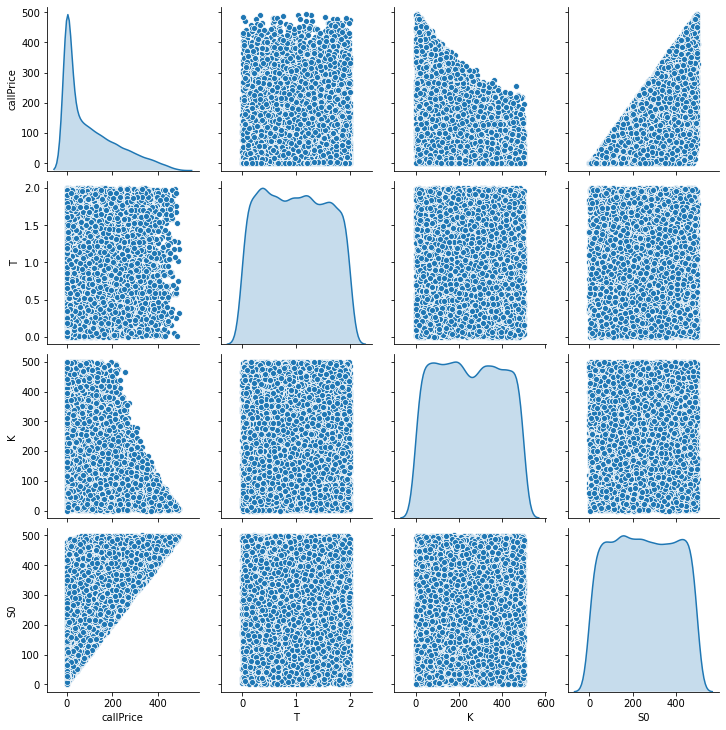

In [6]:
sns.pairplot(df_full [['callPrice','T','K','S0']], diag_kind="kde")

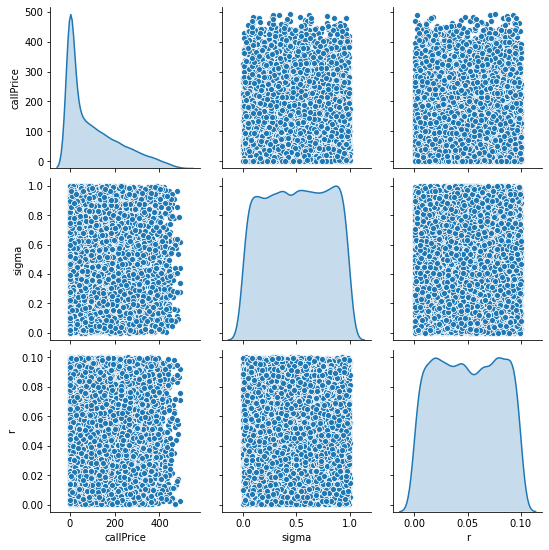

In [7]:
sns.pairplot(df_full [['callPrice','sigma','r']], diag_kind="kde")

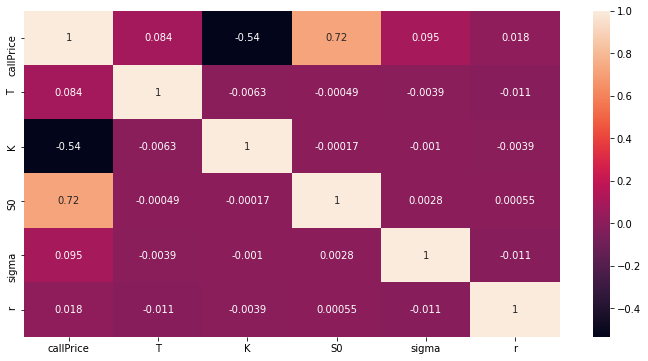

In [8]:
fig=plt.figure(figsize=(12,6))
sns.heatmap(df_full[['callPrice','T','K','S0','sigma','r']].corr(), annot=True)
plt.show()

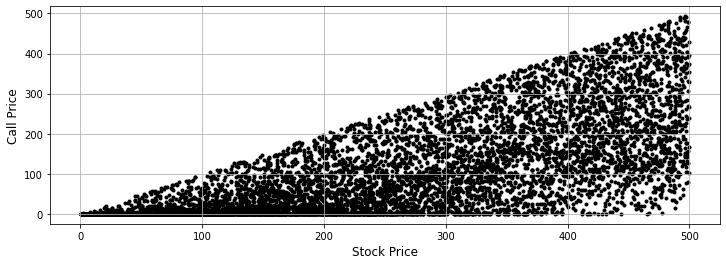

In [9]:
# 3. Split the dataset, Extract, Scale and Visualize

#Split the dataset
train_df = df_full.sample(frac=0.8,random_state=0)
test_df = df_full.drop(train_df.index)

# Extract to numpy arrays
train_data=train_df.to_numpy()
test_data=test_df.to_numpy()
train_data_shape= train_data.shape
test_data_shape= test_data.shape

# Select Stock Price
train_S0= train_data[:,2]

# Select target values or labels
Y_max=train_data[:,5].max()
y_train = train_data [:,5]/Y_max
y_test = test_data[:,5]/Y_max

# Select Feautures
X_max=train_data[:,0:4].max(axis=0)
x_train= train_data[:,0:4]/X_max
x_test =test_data[:,0:4]/X_max

# Visualize target value and most correlated Feautures vs time
fig=plt.figure(figsize=(12,4))
plt.ylabel('Call Price', fontsize=12)
plt.xlabel('Stock Price', fontsize=12)
# Visualize next_ex_rate vs time
plt.scatter(train_S0,y_train*Y_max,marker=".", color="black")

#plt.xticks(np.linspace(0, 350, num=8))
plt.grid()
plt.show()

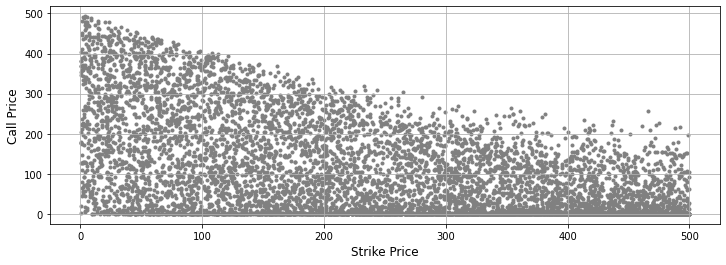

In [10]:
# Select Strike Price
train_K= train_data[:,1]

fig=plt.figure(figsize=(12,4))
plt.ylabel('Call Price', fontsize=12)
plt.xlabel('Strike Price', fontsize=12)
plt.scatter(train_K,y_train*Y_max,marker=".", color="gray")
plt.grid()
plt.show()

In [11]:
# Create and compile a neural network using Keras Sequiential method
# This model has four layers, input, output and two hidden layers
# The architectue (number of layers, activations, etc) was esstablished after many trials

model = keras.Sequential([
    
    # First layer: 
    keras.layers.Dense(32, activation='relu', input_shape=(x_train.shape[1],)),
    
    # Middle layers
    keras.layers.Dense(16, activation='relu'),
    
    # Last layer: 
    keras.layers.Dense(1, activation='relu'),
])

# Compile the model, 
model.compile(optimizer='sgd', loss='mean_squared_error',  metrics=['mse','mae'])

# Print the model characteristics
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                160       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Train the neural network, and visualize errors,
# Define the epochs number for the run
EPOCHS=200
history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=EPOCHS, verbose=1)

Train on 8000 samples, validate on 2000 samples
Epoch 1/200
8000/8000 [==============================] - 1s 118us/step - loss: 0.0278 - mse: 0.0278 - mae: 0.1208 - val_loss: 0.0162 - val_mse: 0.0162 - val_mae: 0.0923
Epoch 2/200
8000/8000 [==============================] - 1s 64us/step - loss: 0.0121 - mse: 0.0121 - mae: 0.0769 - val_loss: 0.0083 - val_mse: 0.0083 - val_mae: 0.0622
Epoch 3/200
8000/8000 [==============================] - 1s 66us/step - loss: 0.0066 - mse: 0.0066 - mae: 0.0551 - val_loss: 0.0050 - val_mse: 0.0050 - val_mae: 0.0469
Epoch 4/200
8000/8000 [==============================] - 0s 62us/step - loss: 0.0042 - mse: 0.0042 - mae: 0.0429 - val_loss: 0.0035 - val_mse: 0.0035 - val_mae: 0.0381
Epoch 5/200
8000/8000 [==============================] - 0s 62us/step - loss: 0.0031 - mse: 0.0031 - mae: 0.0360 - val_loss: 0.0027 - val_mse: 0.0027 - val_mae: 0.0327
Epoch 6/200
8000/8000 [==============================] - 0s 61us/step - loss: 0.0026 - mse: 0.0026 - mae: 0.032

8000/8000 [==============================] - 0s 62us/step - loss: 5.9538e-04 - mse: 5.9538e-04 - mae: 0.0161 - val_loss: 5.4206e-04 - val_mse: 5.4206e-04 - val_mae: 0.0155
Epoch 48/200
8000/8000 [==============================] - 0s 60us/step - loss: 5.8380e-04 - mse: 5.8380e-04 - mae: 0.0159 - val_loss: 5.3109e-04 - val_mse: 5.3109e-04 - val_mae: 0.0153
Epoch 49/200
8000/8000 [==============================] - 0s 60us/step - loss: 5.7396e-04 - mse: 5.7396e-04 - mae: 0.0158 - val_loss: 5.1853e-04 - val_mse: 5.1853e-04 - val_mae: 0.0152
Epoch 50/200
8000/8000 [==============================] - 0s 60us/step - loss: 5.6240e-04 - mse: 5.6240e-04 - mae: 0.0156 - val_loss: 5.0908e-04 - val_mse: 5.0908e-04 - val_mae: 0.0151
Epoch 51/200
8000/8000 [==============================] - 0s 61us/step - loss: 5.5174e-04 - mse: 5.5174e-04 - mae: 0.0155 - val_loss: 5.0116e-04 - val_mse: 5.0116e-04 - val_mae: 0.0150
Epoch 52/200
8000/8000 [==============================] - 0s 60us/step - loss: 5.4266e-0

8000/8000 [==============================] - 0s 61us/step - loss: 3.0673e-04 - mse: 3.0673e-04 - mae: 0.0115 - val_loss: 2.8417e-04 - val_mse: 2.8417e-04 - val_mae: 0.0114
Epoch 92/200
8000/8000 [==============================] - 0s 62us/step - loss: 3.0295e-04 - mse: 3.0295e-04 - mae: 0.0115 - val_loss: 2.8190e-04 - val_mse: 2.8190e-04 - val_mae: 0.0114
Epoch 93/200
8000/8000 [==============================] - 0s 61us/step - loss: 3.0016e-04 - mse: 3.0016e-04 - mae: 0.0114 - val_loss: 2.8202e-04 - val_mse: 2.8202e-04 - val_mae: 0.0114
Epoch 94/200
8000/8000 [==============================] - 0s 60us/step - loss: 2.9661e-04 - mse: 2.9661e-04 - mae: 0.0113 - val_loss: 2.7624e-04 - val_mse: 2.7624e-04 - val_mae: 0.0112
Epoch 95/200
8000/8000 [==============================] - 0s 62us/step - loss: 2.9338e-04 - mse: 2.9338e-04 - mae: 0.0113 - val_loss: 2.7426e-04 - val_mse: 2.7426e-04 - val_mae: 0.0112
Epoch 96/200
8000/8000 [==============================] - 0s 61us/step - loss: 2.8989e-0

8000/8000 [==============================] - 0s 61us/step - loss: 2.1737e-04 - mse: 2.1737e-04 - mae: 0.0096 - val_loss: 2.1349e-04 - val_mse: 2.1349e-04 - val_mae: 0.0098
Epoch 136/200
8000/8000 [==============================] - 0s 60us/step - loss: 2.1666e-04 - mse: 2.1665e-04 - mae: 0.0096 - val_loss: 2.1271e-04 - val_mse: 2.1271e-04 - val_mae: 0.0097
Epoch 137/200
8000/8000 [==============================] - 0s 61us/step - loss: 2.1473e-04 - mse: 2.1473e-04 - mae: 0.0096 - val_loss: 2.1204e-04 - val_mse: 2.1204e-04 - val_mae: 0.0097
Epoch 138/200
8000/8000 [==============================] - 0s 60us/step - loss: 2.1387e-04 - mse: 2.1387e-04 - mae: 0.0096 - val_loss: 2.1038e-04 - val_mse: 2.1038e-04 - val_mae: 0.0097
Epoch 139/200
8000/8000 [==============================] - 0s 61us/step - loss: 2.1239e-04 - mse: 2.1239e-04 - mae: 0.0095 - val_loss: 2.1359e-04 - val_mse: 2.1359e-04 - val_mae: 0.0098
Epoch 140/200
8000/8000 [==============================] - 0s 62us/step - loss: 2.12

8000/8000 [==============================] - 0s 62us/step - loss: 1.8548e-04 - mse: 1.8548e-04 - mae: 0.0089 - val_loss: 1.8519e-04 - val_mse: 1.8519e-04 - val_mae: 0.0091
Epoch 180/200
8000/8000 [==============================] - 0s 61us/step - loss: 1.8503e-04 - mse: 1.8503e-04 - mae: 0.0089 - val_loss: 1.8456e-04 - val_mse: 1.8456e-04 - val_mae: 0.0090
Epoch 181/200
8000/8000 [==============================] - 0s 62us/step - loss: 1.8431e-04 - mse: 1.8431e-04 - mae: 0.0089 - val_loss: 1.8606e-04 - val_mse: 1.8606e-04 - val_mae: 0.0091
Epoch 182/200
8000/8000 [==============================] - 0s 61us/step - loss: 1.8416e-04 - mse: 1.8416e-04 - mae: 0.0088 - val_loss: 1.8416e-04 - val_mse: 1.8416e-04 - val_mae: 0.0090
Epoch 183/200
8000/8000 [==============================] - 0s 60us/step - loss: 1.8338e-04 - mse: 1.8338e-04 - mae: 0.0088 - val_loss: 1.8381e-04 - val_mse: 1.8381e-04 - val_mae: 0.0090
Epoch 184/200
8000/8000 [==============================] - 0s 62us/step - loss: 1.82

In [13]:
# Create a pandas DataFrame from model.fit history dictionary
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail(10)


,val_loss,val_mse,val_mae,loss,mse,mae,epoch
190,0.000180,0.000180,0.008943,0.000180,0.000180,0.008741,190
191,0.000181,0.000181,0.008995,0.000179,0.000179,0.008725,191
192,0.000183,0.000183,0.009002,0.000179,0.000179,0.008720,192
193,0.000180,0.000180,0.008937,0.000179,0.000179,0.008716,193
194,0.000183,0.000183,0.009070,0.000178,0.000178,0.008720,194
195,0.000180,0.000180,0.008958,0.000178,0.000178,0.008683,195
196,0.000178,0.000178,0.008912,0.000177,0.000177,0.008672,196
197,0.000178,0.000178,0.008888,0.000177,0.000177,0.008672,197
198,0.000180,0.000180,0.008985,0.000176,0.000176,0.008658,198
199,0.000177,0.000177,0.008882,0.000176,0.000176,0.008660,199


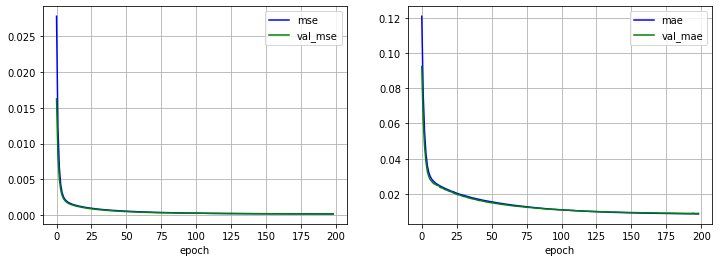

In [14]:
# Visualize 
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(12,4))
hist.iloc[0:-1].plot(x='epoch', y=['mse','val_mse'],ax=ax1,marker="",color=['blue','green'])
plt.grid()
hist.iloc[0:-1].plot(x='epoch', y=['mae','val_mae'],ax=ax2,marker="",color=['blue','green'])
ax1.grid()
ax2.grid()
plt.show()
#Store the figure into a file
#fig.savefig('figs/01_error_history_MonAvg.png')

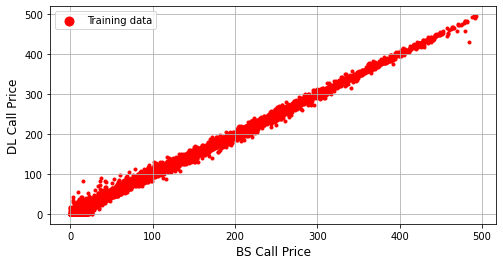

In [15]:
#Test the model vs trainning data and visualize
# Predict and de-scale.
Y_predict_train=model.predict(x_train)*Y_max
Y_train=y_train*Y_max

# Visualize next_ex_rate vs ex_rate on a timeline
fig=plt.figure(figsize=(8,4))
plt.xlabel('BS Call Price', fontsize=12)
plt.ylabel('DL Call Price', fontsize=12)
plt.scatter(Y_train,Y_predict_train,marker=".",color='red')
plt.legend(['Training data','Prediction'],loc="upper left",markerscale=3)
plt.grid()
plt.show()
#Store the figure into a file
#fig.savefig('figs/xxx.png')

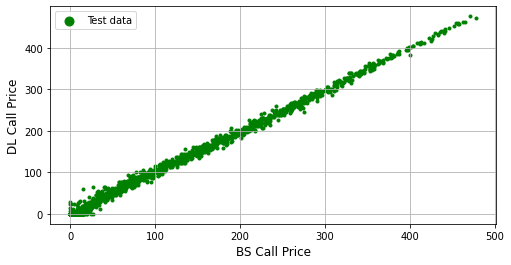

In [16]:
#Test the model vs test data, estimate error, and visualize
# Predict, de-scale, and round
Y_predict_test=model.predict(x_test)*Y_max
Y_predict_test=np.around(Y_predict_test.astype(np.float),2)
Y_test=y_test*Y_max
Y_test=np.around(Y_test.astype(np.float),2)

# Visualize next_ex_rate vs ex_rate on a timeline
fig=plt.figure(figsize=(8,4))
plt.xlabel('BS Call Price', fontsize=12)
plt.ylabel('DL Call Price', fontsize=12)

plt.scatter(Y_test,Y_predict_test,marker=".",color='green')
plt.legend(['Test data'],loc="upper left",markerscale=3)
plt.grid()
plt.show()
#Store the figure into a file
#fig.savefig('figs/xxxg.png')

In [17]:
# Evaluate de model, and print the estimated model errors from testing
loss, val_mse, val_mae  = model.evaluate(x_test,y_test)

print('Test Data Mean Errors in GBP:')
mae_GBP= np.round(val_mae*Y_max,2)
print('Mean average error:', mae_GBP)

mse_GBP =np.round(val_mse*Y_max*Y_max,2)
print('Mean squared error:', mse_GBP)

rmse_GBP =np.round(np.sqrt(val_mse)*Y_max,2)
print('Root mean squared error:', rmse_GBP)


2000/2000 [==============================] - 0s 34us/step
Test Data Mean Errors in GBP:
Mean average error: 4.38
Mean squared error: 43.1
Root mean squared error: 6.56


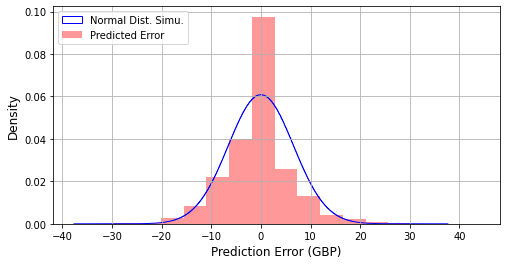

In [18]:
# Visualize the error distribution.
# Reshape labels for comparison

Y_test=Y_test.reshape(test_data_shape[0],1)
Y_predict_test=Y_predict_test.reshape(test_data_shape[0],1)
error=Y_predict_test-Y_test

# Plot Histogram
fig=plt.figure(figsize=(8,4))
plt.ylabel('Density', fontsize=12)
plt.xlabel('Prediction Error (GBP)', fontsize=12)

plt.hist(error,bins=16, density=True, alpha=0.4,color='red')

data = np.random.randn(test_data_shape[0]*200000)*rmse_GBP
plt.hist(data,bins=700,density=True,histtype='step',linewidth=1, color="blue");
plt.legend(['Normal Dist. Simu.','Predicted Error'],loc="upper left",markerscale=3)
plt.grid()
plt.show()
#Store the figure into a file
#fig.savefig('figs/xxxx.png')
